In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/splited-dataset'  # Adjust the path
train_dir = dataset_path + '/train'
val_dir = dataset_path + '/val'
test_dir = dataset_path + '/test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir ,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 2291 images belonging to 3 classes.
Found 286 images belonging to 3 classes.
Found 287 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Flatten, Reshape
#from tensorflow.keras.models import Model

def create_hybrid_model_with_vit(input_shape=(256, 256, 3)):
    input_layer = Input(shape=input_shape)

    # VGG19 for feature extraction
    vgg_model = VGG19(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in vgg_model.layers:
        layer.trainable = False

    # InceptionV3 for feature extraction
    inception_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in inception_model.layers:
        layer.trainable = False

    # Combine features from both models
    vgg_features = GlobalAveragePooling2D()(vgg_model.output)
    inception_features = GlobalAveragePooling2D()(inception_model.output)
    combined_features = Concatenate()([vgg_features, inception_features])

    # Reshape combined features for attention layer
    combined_features_reshaped = Reshape((1, combined_features.shape[-1]))(combined_features)

    # ViT Layer (self-attention)
    vit_attention = MultiHeadAttention(num_heads=8, key_dim=combined_features.shape[-1])(combined_features_reshaped, combined_features_reshaped)
    vit_attention = LayerNormalization()(vit_attention)
    vit_flatten = Flatten()(vit_attention)

    # Classification layer
    output_layer = Dense(3, activation='softmax')(vit_flatten)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Create and compile the updated model
model = create_hybrid_model_with_vit()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 127, 127, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 127, 127, 32)         0         ['batch_normalization_94[0

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50 # You can increase the number of epochs for better results
)


Epoch 1/50
72/72 [==============================] - 746s 10s/step - loss: 2.6255 - accuracy: 0.6508 - val_loss: 0.4367 - val_accuracy: 0.8147
Epoch 2/50
72/72 [==============================] - 151s 2s/step - loss: 0.4226 - accuracy: 0.8385 - val_loss: 0.3354 - val_accuracy: 0.8706
Epoch 3/50
72/72 [==============================] - 152s 2s/step - loss: 0.3006 - accuracy: 0.8817 - val_loss: 0.1654 - val_accuracy: 0.9510
Epoch 4/50
72/72 [==============================] - 152s 2s/step - loss: 0.2149 - accuracy: 0.9088 - val_loss: 0.1060 - val_accuracy: 0.9650
Epoch 5/50
72/72 [==============================] - 152s 2s/step - loss: 0.2028 - accuracy: 0.9245 - val_loss: 0.3624 - val_accuracy: 0.8252
Epoch 6/50
72/72 [==============================] - 152s 2s/step - loss: 0.1685 - accuracy: 0.9345 - val_loss: 0.2934 - val_accuracy: 0.8916
Epoch 7/50
72/72 [==============================] - 153s 2s/step - loss: 0.1386 - accuracy: 0.9467 - val_loss: 0.0733 - val_accuracy: 0.9755
Epoch 8/50
7

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

8/8 [==============================] - 63s 9s/step - loss: 0.1106 - accuracy: 0.9648
Test Loss: 0.11060024052858353, Test Accuracy: 0.96484375


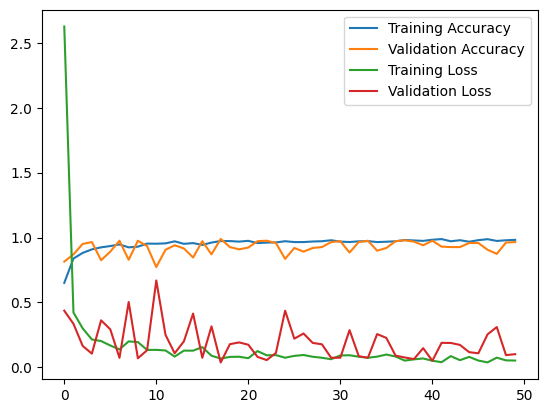

In [ ]:
# Plotting training and validation accuracy/loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Reinitialize the validation generator without shuffling
val_generator_no_shuffle = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensures the order of the data is preserved
)


Found 286 images belonging to 3 classes.


In [ ]:
# Reset the generator and make predictions
val_generator_no_shuffle.reset()
preds = model.predict(val_generator_no_shuffle, verbose=1)


9/9 [==============================] - 12s 1s/step


Classification Report
                       precision    recall  f1-score   support

Potato___Early_blight       0.96      1.00      0.98       100
     Potato___Healthy       1.00      0.93      0.96        86
 Potato___Late_blight       0.94      0.96      0.95       100

             accuracy                           0.97       286
            macro avg       0.97      0.96      0.96       286
         weighted avg       0.97      0.97      0.96       286



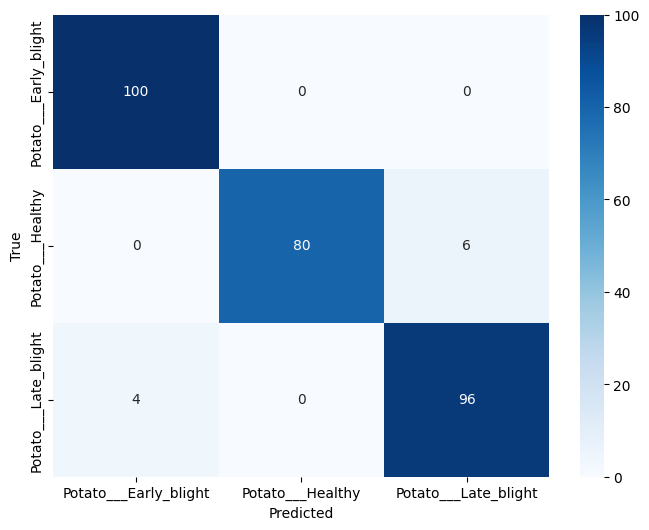

In [ ]:
# Extract true labels and predicted labels
y_pred = preds.argmax(axis=1)
y_true = val_generator_no_shuffle.classes  # These are now aligned since shuffle=False
class_labels = list(val_generator_no_shuffle.class_indices.keys())

# Print classification report and confusion matrix
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
model.save('hybrid.keras')

In [ ]:
# Get true labels
y_true = test_generator.classes
y_scores=preds

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

9/9 [==============================] - 10s 1s/step


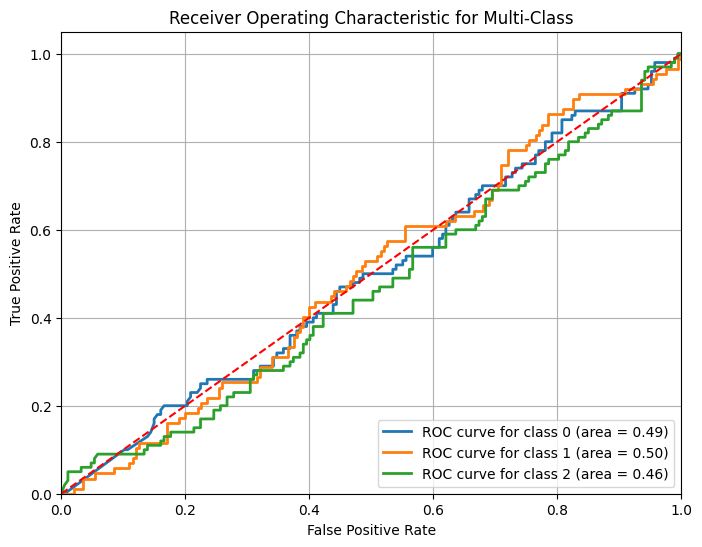

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have your true labels and predicted probabilities
y_true = test_generator.classes  # True labels (287,)
y_scores = model.predict(test_generator)  # Predicted probabilities (287, 3)

# Binarize the output for multi-class ROC
n_classes = 3  # Update this to the number of classes you have
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Replace with your class labels

# Initialize ROC curve and AUC lists
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
# Make predictions with your model
y_scores = model.predict(test_generator)

# Check the number of samples
num_samples = len(test_generator)
print("Number of samples in test generator:", num_samples)

# Check shape of predictions again
print("Predicted probabilities shape:", y_scores.shape)

# If necessary, get the true labels again from the generator
y_true = test_generator.classes
print("True labels shape after re-checking:", y_true.shape)

# If y_scores is still not aligned, consider the following:
if y_scores.shape[0] != len(y_true):
    print("Mismatch between predicted scores and true labels. Adjusting...")

9/9 [==============================] - 10s 1s/step
Number of samples in test generator: 9
Predicted probabilities shape: (287, 3)
True labels shape after re-checking: (287,)


9/9 [==============================] - 10s 1s/step


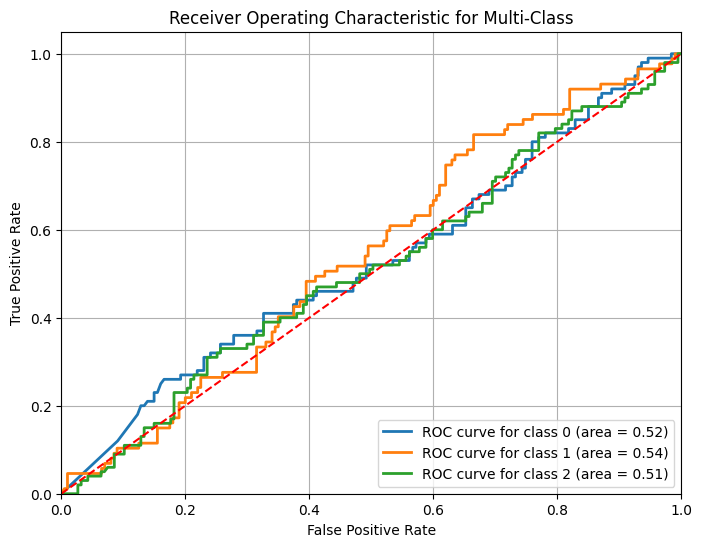

In [ ]:
# prompt: give code for roc curve and auc curve for my model

# Assuming you have your true labels and predicted probabilities
y_true = test_generator.classes  # True labels
y_scores = model.predict(test_generator)  # Predicted probabilities

# Binarize the output for multi-class ROC
n_classes = 3  # Update this to the number of classes you have
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Replace with your class labels

# Initialize ROC curve and AUC lists
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

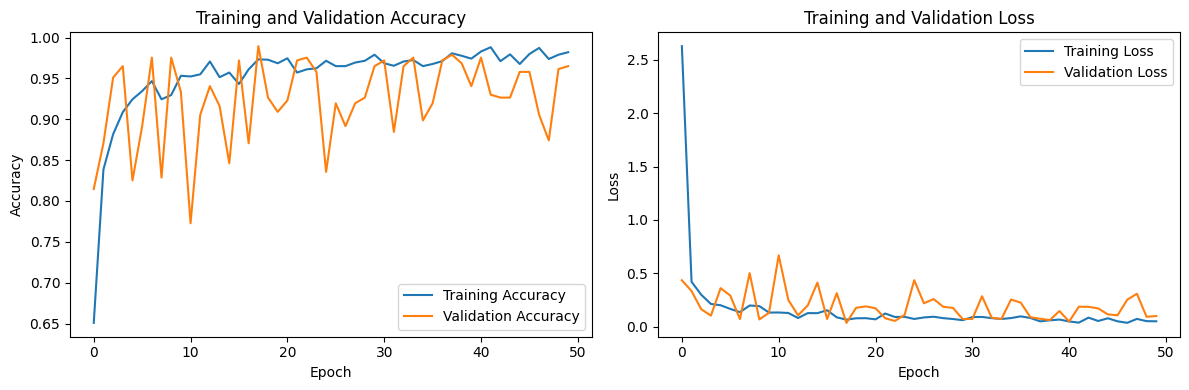

In [ ]:
# prompt: give code train and validation accuracy graph

# Plotting training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()